In [1]:
import pandas as pd
import numpy as np
import datetime

from pyspark.sql import  SparkSession
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark import SQLContext
import matplotlib.pyplot as plt

from pyspark.sql.functions import col, countDistinct
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import year, month, dayofmonth

import matplotlib as plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic


# LSTM
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

/usr/local/anaconda/python2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/usr/local/anaconda/python2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
sc = SparkContext()
sqlContext = SQLContext(sc)

# Transaction & Store Data

In [3]:
transaction_data = sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/transactions_store44.csv",header = True,inferSchema = True)

In [4]:
stores_data=sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/stores.csv",header = True,inferSchema = True)

In [5]:
sales_df =pd.merge(transaction_data.toPandas(),stores_data.toPandas(),how='left')
sales_df.describe()

,store_nbr,transactions,cluster
count,1089.0,1089.000000,1089.0
mean,44.0,4325.125803,5.0
std,0.0,749.300106,0.0
min,44.0,2333.000000,5.0
25%,44.0,3797.000000,5.0
50%,44.0,4133.000000,5.0
75%,44.0,4787.000000,5.0
max,44.0,8359.000000,5.0


In [6]:
sales_df.head()

,date,store_nbr,transactions,city,state,type,cluster
0,2013-01-02,44,4821,Quito,Pichincha,A,5
1,2013-01-03,44,3618,Quito,Pichincha,A,5
2,2013-01-04,44,4169,Quito,Pichincha,A,5
3,2013-01-05,44,4921,Quito,Pichincha,A,5
4,2013-01-06,44,4925,Quito,Pichincha,A,5


In [7]:
sales_df.date.min()

Timestamp('2013-01-02 00:00:00')

In [8]:
sales_df.date.max()

Timestamp('2015-12-31 00:00:00')

# Holiday Data

In [9]:
holiday_data = sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/holidays_events_2013_2015.csv",header = True,inferSchema = True)
holiday_data_df = holiday_data.toPandas()

In [10]:
holiday_data_df.head(2)

,date,type,locale,locale_name,description,transferred
0,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False


In [11]:
holiday_data_df['date'] = pd.to_datetime(holiday_data_df['date'], format='%b %d, %Y')
sales_df['date'] = pd.to_datetime(sales_df['date'], format='%b %d, %Y')

In [12]:
# Isolating events that do not correspond to holidays
events=holiday_data_df.loc[holiday_data_df.type=='Event']
holiday_data_df=holiday_data_df.loc[holiday_data_df.type!='Event']

In [13]:
# Adjuusting this variable to show all holidays
sales_df['year'],sales_df['week'],sales_df['day']=list(zip(*sales_df.date.apply(lambda x: x.isocalendar())))

# Creating a categorical variable showing weekends
sales_df['dayoff']=[x in [6,7] for x in sales_df.day]

# Adjuusting this variable to show all holidays
for (d,t,l,n) in zip(holiday_data_df.date,holiday_data_df.type,holiday_data_df.locale,holiday_data_df.locale_name):
  if t!='Work Day':
    if l=='National':
      sales_df.loc[sales_df.date==d,'dayoff']=True
    elif l=='Regional':
      sales_df.loc[(sales_df.date==d)&(sales_df.state==n),'dayoff']=True
    else:
      sales_df.loc[(sales_df.date==d)&(sales_df.city==n),'dayoff']=True
  else:
    sales_df.loc[(sales_df.date==d),'dayoff']=False

In [14]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1089 entries, 0 to 1088
Data columns (total 11 columns):
date            1089 non-null datetime64[ns]
store_nbr       1089 non-null int64
transactions    1089 non-null int64
city            1089 non-null object
state           1089 non-null object
type            1089 non-null object
cluster         1089 non-null int64
year            1089 non-null int64
week            1089 non-null int64
day             1089 non-null int64
dayoff          1089 non-null bool
dtypes: bool(1), datetime64[ns](1), int64(6), object(3)
memory usage: 94.6+ KB


In [15]:
holiday_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 169
Data columns (total 6 columns):
date           149 non-null datetime64[ns]
type           149 non-null object
locale         149 non-null object
locale_name    149 non-null object
description    149 non-null object
transferred    149 non-null bool
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 7.1+ KB


In [16]:
sales_df.head()

,date,store_nbr,transactions,city,state,type,cluster,year,week,day,dayoff
0,2013-01-02,44,4821,Quito,Pichincha,A,5,2013,1,3,False
1,2013-01-03,44,3618,Quito,Pichincha,A,5,2013,1,4,False
2,2013-01-04,44,4169,Quito,Pichincha,A,5,2013,1,5,False
3,2013-01-05,44,4921,Quito,Pichincha,A,5,2013,1,6,False
4,2013-01-06,44,4925,Quito,Pichincha,A,5,2013,1,7,True


In [17]:
sales_df.count()

date            1089
store_nbr       1089
transactions    1089
city            1089
state           1089
type            1089
cluster         1089
year            1089
week            1089
day             1089
dayoff          1089
dtype: int64

# Oil Data

In [18]:
sdfOil = sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/oil.csv",header = True,inferSchema = True)

# Train Data

In [19]:
train_data = sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/train_store44.csv",header = True,inferSchema = True)

In [20]:
sqlContext.registerDataFrameAsTable(train_data, "traintbl")
train_2015 = sqlContext.sql("select *  from traintbl where date < '2016-01-01 00:00:00'")

In [21]:
train_2015.head(2)

[Row(id=32292, date=datetime.datetime(2013, 1, 2, 0, 0), store_nbr=44, item_nbr=103520, unit_sales=12.0, onpromotion=None),
 Row(id=32293, date=datetime.datetime(2013, 1, 2, 0, 0), store_nbr=44, item_nbr=103665, unit_sales=20.0, onpromotion=None)]

In [22]:
#trainTbl2015 = sqlContext.sql("SELECT date as date,(sum(unit_sales)*count(item_nbr)) as total_sales from traintbl where year(date) <='2015' group by date order by date ")
#trainTbl2015.show()

In [23]:
# Onpromotion field can't be used as it is strongly associated with Item_nbr
#trainTbl2015 = sqlContext.sql("SELECT date as date,(sum(unit_sales)) as total_sales,onpromotion as onpromotion from traintbl where year(date) <='2015'  group by date,onpromotion order by date ")
#trainTbl2015.show()
#trainTbl2015 = trainTbl2015.fillna({'onpromotion':0})

In [24]:
trainTbl2015 = sqlContext.sql("SELECT date as date,(sum(unit_sales)) as total_sales from traintbl where year(date) <='2015'  group by date order by date ")
trainTbl2015.show()

+-------------------+------------------+
|               date|       total_sales|
+-------------------+------------------+
|2013-01-02 00:00:00|         30095.181|
|2013-01-03 00:00:00|20447.056999999997|
|2013-01-04 00:00:00|22795.799000000003|
|2013-01-05 00:00:00|31382.508000000005|
|2013-01-06 00:00:00|         36069.345|
|2013-01-07 00:00:00|         21025.329|
|2013-01-08 00:00:00|         33993.257|
|2013-01-09 00:00:00|         21296.042|
|2013-01-10 00:00:00|15522.827999999998|
|2013-01-11 00:00:00|19738.474999999995|
|2013-01-12 00:00:00|         25418.678|
|2013-01-13 00:00:00|31129.350000000002|
|2013-01-14 00:00:00| 17518.41199999999|
|2013-01-15 00:00:00|15761.720999999996|
|2013-01-16 00:00:00|21994.872999999996|
|2013-01-17 00:00:00|14999.144999999997|
|2013-01-18 00:00:00|         19238.575|
|2013-01-19 00:00:00|29145.704000000005|
|2013-01-20 00:00:00|31897.753000000004|
|2013-01-21 00:00:00|17632.768000000007|
+-------------------+------------------+
only showing top

In [25]:
type(trainTbl2015)

pyspark.sql.dataframe.DataFrame

In [26]:
train_df =pd.merge(trainTbl2015.toPandas(),sales_df,how='left')
train_df.describe()

,total_sales,store_nbr,transactions,cluster,year,week,day
count,1089.000000,1089.0,1089.000000,1089.0,1089.000000,1089.000000,1089.000000
mean,32352.572317,44.0,4325.125803,5.0,2014.004591,26.620753,4.000000
std,13420.765145,0.0,749.300106,0.0,0.817421,14.982047,2.003214
min,9067.748000,44.0,2333.000000,5.0,2013.000000,1.000000,1.000000
25%,21326.734000,44.0,3797.000000,5.0,2013.000000,14.000000,2.000000
50%,30586.076000,44.0,4133.000000,5.0,2014.000000,27.000000,4.000000
75%,39148.231000,44.0,4787.000000,5.0,2015.000000,40.000000,6.000000
max,78070.753000,44.0,8359.000000,5.0,2015.000000,53.000000,7.000000


In [27]:
train_df.head()

,date,total_sales,store_nbr,transactions,city,state,type,cluster,year,week,day,dayoff
0,2013-01-02,30095.181,44,4821,Quito,Pichincha,A,5,2013,1,3,False
1,2013-01-03,20447.057,44,3618,Quito,Pichincha,A,5,2013,1,4,False
2,2013-01-04,22795.799,44,4169,Quito,Pichincha,A,5,2013,1,5,False
3,2013-01-05,31382.508,44,4921,Quito,Pichincha,A,5,2013,1,6,False
4,2013-01-06,36069.345,44,4925,Quito,Pichincha,A,5,2013,1,7,True


In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1089 entries, 0 to 1088
Data columns (total 12 columns):
date            1089 non-null datetime64[ns]
total_sales     1089 non-null float64
store_nbr       1089 non-null int64
transactions    1089 non-null int64
city            1089 non-null object
state           1089 non-null object
type            1089 non-null object
cluster         1089 non-null int64
year            1089 non-null int64
week            1089 non-null int64
day             1089 non-null int64
dayoff          1089 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(1), int64(6), object(3)
memory usage: 103.2+ KB


In [29]:
# Adding feature - Taking 5 lags for prediction LSTM
for obs in range(1,6):
  train_df['T_'+ str(obs)]=train_df.transactions.shift(obs)

In [30]:
train_df.head(6)

,date,total_sales,store_nbr,transactions,city,state,type,cluster,year,week,day,dayoff,T_1,T_2,T_3,T_4,T_5
0,2013-01-02,30095.181,44,4821,Quito,Pichincha,A,5,2013,1,3,False,NaN,NaN,NaN,NaN,NaN
1,2013-01-03,20447.057,44,3618,Quito,Pichincha,A,5,2013,1,4,False,4821.0,NaN,NaN,NaN,NaN
2,2013-01-04,22795.799,44,4169,Quito,Pichincha,A,5,2013,1,5,False,3618.0,4821.0,NaN,NaN,NaN
3,2013-01-05,31382.508,44,4921,Quito,Pichincha,A,5,2013,1,6,False,4169.0,3618.0,4821.0,NaN,NaN
4,2013-01-06,36069.345,44,4925,Quito,Pichincha,A,5,2013,1,7,True,4921.0,4169.0,3618.0,4821.0,NaN
5,2013-01-07,21025.329,44,3871,Quito,Pichincha,A,5,2013,2,1,False,4925.0,4921.0,4169.0,3618.0,4821.0


In [31]:
#train_df.onpromotion=train_df.onpromotion.astype('int')
train_df.dayoff=train_df.dayoff.astype('int')
train_df.date = pd.to_datetime(train_df.date)
train_df =train_df.fillna(0)

In [32]:
train_df.head(10)

,date,total_sales,store_nbr,transactions,city,state,type,cluster,year,week,day,dayoff,T_1,T_2,T_3,T_4,T_5
0,2013-01-02,30095.181,44,4821,Quito,Pichincha,A,5,2013,1,3,0,0.0,0.0,0.0,0.0,0.0
1,2013-01-03,20447.057,44,3618,Quito,Pichincha,A,5,2013,1,4,0,4821.0,0.0,0.0,0.0,0.0
2,2013-01-04,22795.799,44,4169,Quito,Pichincha,A,5,2013,1,5,0,3618.0,4821.0,0.0,0.0,0.0
3,2013-01-05,31382.508,44,4921,Quito,Pichincha,A,5,2013,1,6,0,4169.0,3618.0,4821.0,0.0,0.0
4,2013-01-06,36069.345,44,4925,Quito,Pichincha,A,5,2013,1,7,1,4921.0,4169.0,3618.0,4821.0,0.0
5,2013-01-07,21025.329,44,3871,Quito,Pichincha,A,5,2013,2,1,0,4925.0,4921.0,4169.0,3618.0,4821.0
6,2013-01-08,33993.257,44,3593,Quito,Pichincha,A,5,2013,2,2,0,3871.0,4925.0,4921.0,4169.0,3618.0
7,2013-01-09,21296.042,44,4006,Quito,Pichincha,A,5,2013,2,3,0,3593.0,3871.0,4925.0,4921.0,4169.0
8,2013-01-10,15522.828,44,3323,Quito,Pichincha,A,5,2013,2,4,0,4006.0,3593.0,3871.0,4925.0,4921.0
9,2013-01-11,19738.475,44,3873,Quito,Pichincha,A,5,2013,2,5,0,3323.0,4006.0,3593.0,3871.0,4925.0


In [33]:
ts=train_df[['date','transactions']].set_index('date')

In [34]:
ts=ts.transactions.astype('float')

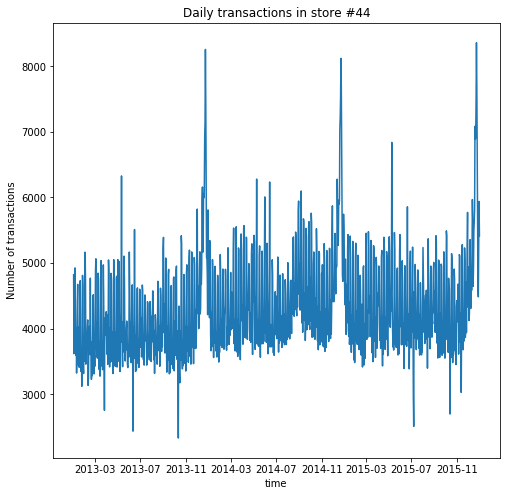

In [35]:
plt.figure(figsize=(8,8))
plt.title('Daily transactions in store #44')
plt.xlabel('time')
plt.ylabel('Number of transactions')
plt.plot(ts);

In [36]:
xmask=(train_df.date>=pd.to_datetime("12/01/2015")) & (train_df.date<=pd.to_datetime("12/30/2015"))


In [37]:
xmas_month=train_df.loc[xmask]

In [38]:
xmas_month=xmas_month[['date','transactions']].set_index('date')


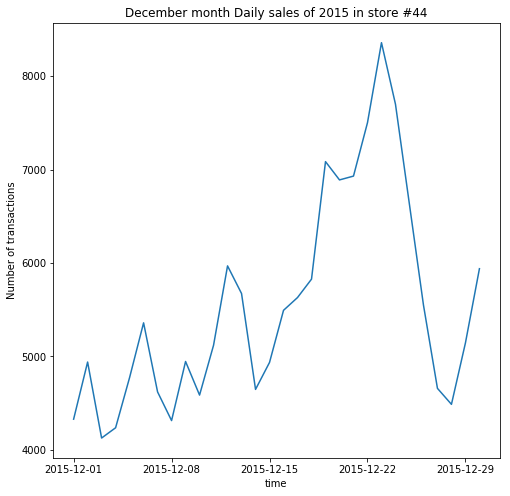

In [39]:
plt.figure(figsize=(8,8))
plt.title('December month Daily sales of 2015 in store #44')
plt.xlabel('time')
plt.ylabel('Number of transactions')
plt.plot(xmas_month);
# First week of october has the highest sales in 2015, after 10th sales goes down drastically till 15th

In [40]:
clean_data=train_df[['day','dayoff','total_sales','T_1','T_2','T_3','T_4','T_5','transactions']]

In [41]:
clean_data.head(6)

,day,dayoff,total_sales,T_1,T_2,T_3,T_4,T_5,transactions
0,3,0,30095.181,0.0,0.0,0.0,0.0,0.0,4821
1,4,0,20447.057,4821.0,0.0,0.0,0.0,0.0,3618
2,5,0,22795.799,3618.0,4821.0,0.0,0.0,0.0,4169
3,6,0,31382.508,4169.0,3618.0,4821.0,0.0,0.0,4921
4,7,1,36069.345,4921.0,4169.0,3618.0,4821.0,0.0,4925
5,1,0,21025.329,4925.0,4921.0,4169.0,3618.0,4821.0,3871


In [42]:
# Predict with validation_split=0.3
X_clean_data=clean_data[['day','dayoff','total_sales','T_1','T_2','T_3','T_4','T_5']]
Y_clean_data=clean_data['transactions']

In [43]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler=StandardScaler()
X_clean_data_scaled=scaler.fit_transform(X_clean_data)
Y_clean_data_scaled=scaler.fit_transform(Y_clean_data.reshape(len(Y_clean_data),1))

/usr/local/anaconda/python2/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.
/usr/local/anaconda/python2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [44]:
X_clean_reshaped=X_clean_data_scaled.reshape((X_clean_data_scaled.shape[0],1,X_clean_data_scaled.shape[1]))

In [45]:
model=Sequential()
model.add(LSTM(5,input_shape=(1,8),kernel_initializer='normal',activation='relu')) # 5 memory cells
model.add(Dense(1,kernel_initializer='normal'))
model.compile(loss='mean_squared_error',optimizer='adam')

In [46]:
history=model.fit(X_clean_reshaped,Y_clean_data_scaled,validation_split=0.3,
                  epochs=50,batch_size=7,verbose=2) # Every 7 records updates weights in each iteration

#- around 15%  - 1s - loss: 0.1565 - val_loss: 0.2102  for 50th iteration

Train on 762 samples, validate on 327 samples
Epoch 1/50
 - 2s - loss: 0.9631 - val_loss: 0.9273
Epoch 2/50
 - 1s - loss: 0.7485 - val_loss: 0.5688
Epoch 3/50
 - 1s - loss: 0.4222 - val_loss: 0.3436
Epoch 4/50
 - 1s - loss: 0.3129 - val_loss: 0.3057
Epoch 5/50
 - 1s - loss: 0.2871 - val_loss: 0.2961
Epoch 6/50
 - 1s - loss: 0.2747 - val_loss: 0.2863
Epoch 7/50
 - 1s - loss: 0.2676 - val_loss: 0.2797
Epoch 8/50
 - 1s - loss: 0.2616 - val_loss: 0.2715
Epoch 9/50
 - 1s - loss: 0.2545 - val_loss: 0.2676
Epoch 10/50
 - 1s - loss: 0.2492 - val_loss: 0.2655
Epoch 11/50
 - 1s - loss: 0.2452 - val_loss: 0.2595
Epoch 12/50
 - 1s - loss: 0.2412 - val_loss: 0.2573
Epoch 13/50
 - 1s - loss: 0.2362 - val_loss: 0.2537
Epoch 14/50
 - 0s - loss: 0.2320 - val_loss: 0.2518
Epoch 15/50
 - 1s - loss: 0.2284 - val_loss: 0.2488
Epoch 16/50
 - 2s - loss: 0.2233 - val_loss: 0.2454
Epoch 17/50
 - 2s - loss: 0.2200 - val_loss: 0.2463
Epoch 18/50
 - 3s - loss: 0.2153 - val_loss: 0.2391
Epoch 19/50
 - 1s - loss: 0

In [47]:
training_data =train_df[train_df.date < pd.to_datetime("01/01/2014")]
val_mask=(train_df.date >= pd.to_datetime("01/01/2014") ) & (train_df.date < pd.to_datetime("01/01/2015"))
val_data=train_df.loc[val_mask]
test_data=train_df[train_df.date >= pd.to_datetime("01/01/2015")]

In [48]:
training_data.head(2)

,date,total_sales,store_nbr,transactions,city,state,type,cluster,year,week,day,dayoff,T_1,T_2,T_3,T_4,T_5
0,2013-01-02,30095.181,44,4821,Quito,Pichincha,A,5,2013,1,3,0,0.0,0.0,0.0,0.0,0.0
1,2013-01-03,20447.057,44,3618,Quito,Pichincha,A,5,2013,1,4,0,4821.0,0.0,0.0,0.0,0.0


In [49]:
val_data.head(2)

,date,total_sales,store_nbr,transactions,city,state,type,cluster,year,week,day,dayoff,T_1,T_2,T_3,T_4,T_5
363,2014-01-02,47024.6300,44,4422,Quito,Pichincha,A,5,2014,1,4,0,5085.0,5810.0,4214.0,4822.0,5087.0
364,2014-01-03,42599.8299,44,4167,Quito,Pichincha,A,5,2014,1,5,0,4422.0,5085.0,5810.0,4214.0,4822.0


In [50]:
test_data

,date,total_sales,store_nbr,transactions,city,state,type,cluster,year,week,day,dayoff,T_1,T_2,T_3,T_4,T_5
726,2015-01-02,33283.114,44,4621,Quito,Pichincha,A,5,2015,1,5,1,5524.0,5745.0,4868.0,4721.0,4813.0
727,2015-01-03,32598.434,44,4364,Quito,Pichincha,A,5,2015,1,6,1,4621.0,5524.0,5745.0,4868.0,4721.0
728,2015-01-04,41727.042,44,5061,Quito,Pichincha,A,5,2015,1,7,1,4364.0,4621.0,5524.0,5745.0,4868.0
729,2015-01-05,30253.240,44,4475,Quito,Pichincha,A,5,2015,2,1,0,5061.0,4364.0,4621.0,5524.0,5745.0
730,2015-01-06,22941.504,44,3912,Quito,Pichincha,A,5,2015,2,2,0,4475.0,5061.0,4364.0,4621.0,5524.0
731,2015-01-07,29337.046,44,4674,Quito,Pichincha,A,5,2015,2,3,0,3912.0,4475.0,5061.0,4364.0,4621.0
732,2015-01-08,22956.348,44,4086,Quito,Pichincha,A,5,2015,2,4,0,4674.0,3912.0,4475.0,5061.0,4364.0
733,2015-01-09,25093.571,44,4242,Quito,Pichincha,A,5,2015,2,5,0,4086.0,4674.0,3912.0,4475.0,5061.0
734,2015-01-10,35426.942,44,5235,Quito,Pichincha,A,5,2015,2,6,0,4242.0,4086.0,4674.0,3912.0,4475.0
735,2015-01-11,42871.092,44,5434,Quito,Pichincha,A,5,2015,2,7,1,5235.0,4242.0,4086.0,4674.0,3912.0


In [51]:
clean_train=training_data[['day','dayoff','total_sales','T_1','T_2','T_3','T_4','T_5','transactions']]
clean_val=val_data[['day','dayoff','total_sales','T_1','T_2','T_3','T_4','T_5','transactions']]
clean_test=test_data[['day','dayoff','total_sales','T_1','T_2','T_3','T_4','T_5','transactions']]

In [52]:
clean_train.head(2)

,day,dayoff,total_sales,T_1,T_2,T_3,T_4,T_5,transactions
0,3,0,30095.181,0.0,0.0,0.0,0.0,0.0,4821
1,4,0,20447.057,4821.0,0.0,0.0,0.0,0.0,3618


In [53]:
clean_val.head(2)

,day,dayoff,total_sales,T_1,T_2,T_3,T_4,T_5,transactions
363,4,0,47024.6300,5085.0,5810.0,4214.0,4822.0,5087.0,4422
364,5,0,42599.8299,4422.0,5085.0,5810.0,4214.0,4822.0,4167


In [54]:
clean_test.head(2)

,day,dayoff,total_sales,T_1,T_2,T_3,T_4,T_5,transactions
726,5,1,33283.114,5524.0,5745.0,4868.0,4721.0,4813.0,4621
727,6,1,32598.434,4621.0,5524.0,5745.0,4868.0,4721.0,4364


In [55]:
X_train,y_train= clean_train.drop(["transactions"],axis=1),clean_train.transactions
X_test,y_test= clean_test.drop(["transactions"],axis=1),clean_test.transactions
X_val,y_val= clean_val.drop(["transactions"],axis=1),clean_val.transactions


In [56]:
X_train.head(2)

,day,dayoff,total_sales,T_1,T_2,T_3,T_4,T_5
0,3,0,30095.181,0.0,0.0,0.0,0.0,0.0
1,4,0,20447.057,4821.0,0.0,0.0,0.0,0.0


In [57]:
# Normalize/Standardize the input and output  data
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.fit_transform(X_test)
X_val_scaled=scaler.fit_transform(X_val)

y_train_scaled=scaler.fit_transform(y_train.reshape(len(y_train),1))
y_test_scaled=scaler.fit_transform(y_test.reshape(len(y_test),1))
y_val_scaled=scaler.fit_transform(y_val.reshape(len(y_val),1))

/usr/local/anaconda/python2/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/usr/local/anaconda/python2/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':
/usr/local/anaconda/python2/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.


In [58]:
X_train_scaled.shape

(363, 8)

In [59]:
X_train_scaled

array([[-5.00860734e-01, -6.80962317e-01,  1.00426255e+00, ...,
        -5.01564185e+00, -4.84046885e+00, -4.68493780e+00],
       [-1.37599103e-03, -6.80962317e-01, -3.49949191e-01, ...,
        -5.01564185e+00, -4.84046885e+00, -4.68493780e+00],
       [ 4.98108752e-01, -6.80962317e-01, -2.02795070e-02, ...,
        -5.01564185e+00, -4.84046885e+00, -4.68493780e+00],
       ...,
       [ 1.49707824e+00,  1.46851004e+00,  2.97864788e-01, ...,
         1.24361089e+00,  4.02007562e+00,  4.87343068e+00],
       [-1.49983022e+00, -6.80962317e-01,  1.42124577e+00, ...,
         1.24730439e+00,  1.21993853e+00,  3.92060398e+00],
       [-1.00034548e+00,  1.46851004e+00, -1.51804930e-01, ...,
         9.21045147e-01,  1.22351470e+00,  1.20105364e+00]])

In [60]:
X_test_scaled.shape

(363, 8)

In [61]:
X_val_scaled.shape

(363, 8)

In [62]:
# LSTM accepts inputs in 3 Dimension format i.e  Samples, Time steps, feautes
X_t_reshaped=X_train_scaled.reshape((X_train_scaled.shape[0],1,X_train_scaled.shape[1]))
X_val_reshaped=X_val_scaled.reshape((X_val_scaled.shape[0],1,X_val_scaled.shape[1]))

In [63]:
X_t_reshaped.shape

(363, 1, 8)

In [64]:
model2=Sequential()
model2.add(LSTM(5,input_shape=(1,8),kernel_initializer='normal',activation='relu'))
model2.add(Dense(1,kernel_initializer='normal'))
model2.compile(loss='mean_squared_error',optimizer='adam') #,metrics=['mse', 'mae', 'mape', 'cosine']


In [65]:
# Manual validation
history=model2.fit(X_t_reshaped,y_train_scaled,validation_data=(X_val_reshaped,y_val_scaled),
                  epochs=50,batch_size=7,verbose=2)
#  10 % Loss: 0.0017 - val_loss: 0.0026

Train on 363 samples, validate on 363 samples
Epoch 1/50
 - 2s - loss: 0.9988 - val_loss: 0.9949
Epoch 2/50
 - 1s - loss: 0.9870 - val_loss: 0.9694
Epoch 3/50
 - 1s - loss: 0.9341 - val_loss: 0.8777
Epoch 4/50
 - 1s - loss: 0.7967 - val_loss: 0.7018
Epoch 5/50
 - 1s - loss: 0.6007 - val_loss: 0.5187
Epoch 6/50
 - 1s - loss: 0.4385 - val_loss: 0.4116
Epoch 7/50
 - 1s - loss: 0.3542 - val_loss: 0.3541
Epoch 8/50
 - 1s - loss: 0.3071 - val_loss: 0.3268
Epoch 9/50
 - 0s - loss: 0.2748 - val_loss: 0.3120
Epoch 10/50
 - 1s - loss: 0.2547 - val_loss: 0.3004
Epoch 11/50
 - 1s - loss: 0.2372 - val_loss: 0.2989
Epoch 12/50
 - 1s - loss: 0.2273 - val_loss: 0.2973
Epoch 13/50
 - 1s - loss: 0.2193 - val_loss: 0.2978
Epoch 14/50
 - 1s - loss: 0.2109 - val_loss: 0.2988
Epoch 15/50
 - 1s - loss: 0.2062 - val_loss: 0.2996
Epoch 16/50
 - 1s - loss: 0.2012 - val_loss: 0.2997
Epoch 17/50
 - 0s - loss: 0.1957 - val_loss: 0.3011
Epoch 18/50
 - 1s - loss: 0.1906 - val_loss: 0.3011
Epoch 19/50
 - 0s - loss: 0

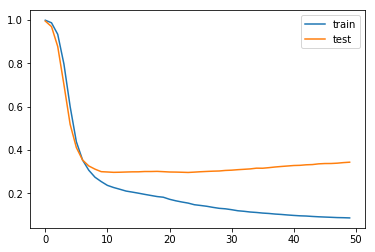

In [66]:

plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()

In [67]:
X_te_reshaped=X_test_scaled.reshape((X_test_scaled.shape[0],1,X_test_scaled.shape[1]))
res1=model2.predict(X_te_reshaped)
test_data['LS_PRED']=res1


/usr/local/anaconda/python2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [68]:
test_data.head(2)

,date,total_sales,store_nbr,transactions,city,state,type,cluster,year,week,day,dayoff,T_1,T_2,T_3,T_4,T_5,LS_PRED
726,2015-01-02,33283.114,44,4621,Quito,Pichincha,A,5,2015,1,5,1,5524.0,5745.0,4868.0,4721.0,4813.0,0.192543
727,2015-01-03,32598.434,44,4364,Quito,Pichincha,A,5,2015,1,6,1,4621.0,5524.0,5745.0,4868.0,4721.0,0.021309


In [69]:
res2=scaler.inverse_transform(res1)

In [70]:
test_data['LS_PRED_inv']=res2

/usr/local/anaconda/python2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [71]:
test_data.head(2)

,date,total_sales,store_nbr,transactions,city,state,type,cluster,year,week,day,dayoff,T_1,T_2,T_3,T_4,T_5,LS_PRED,LS_PRED_inv
726,2015-01-02,33283.114,44,4621,Quito,Pichincha,A,5,2015,1,5,1,5524.0,5745.0,4868.0,4721.0,4813.0,0.192543,4610.989746
727,2015-01-03,32598.434,44,4364,Quito,Pichincha,A,5,2015,1,6,1,4621.0,5524.0,5745.0,4868.0,4721.0,0.021309,4485.596191


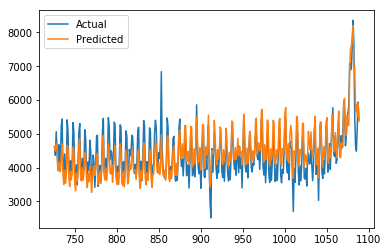

In [72]:
plt.plot(test_data['transactions'],label='Actual')
plt.plot(test_data['LS_PRED_inv'],label='Predicted')
plt.legend()

# Keras Regression on top of LSTM 

In [ ]:
def DL_model2():
    model = Sequential()
    
    model.add(LSTM(5,input_shape=(1,8),kernel_initializer='normal',activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
from sklearn.model_selection import StratifiedKFold
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
seed=7
np.random.seed(seed)
estimator=KerasRegressor(build_fn=DL_model2,epochs=50,batch_size=5,verbose=0)
kfold=KFold(n_splits=3,random_state=seed)
results=cross_val_score(estimator,X_clean_reshaped,Y_clean_data_scaled,cv=kfold)
print("Baseline : %.2f(%.2f) MSE" %(results.mean(),results.std()))